Set up imports and annotations for all analyses

In [1]:
#add pipeline to path
import sys
import datetime
pipeline_dir = '../ribo_seq/'
if pipeline_dir not in sys.path:
    sys.path.append(pipeline_dir)
    
import ribo_seq_main
import ribo_settings
import ribo_utils
import ribo_lib
import ribo_qc
import ribo_plotting
import ribo_tables

def current_time():
    return datetime.datetime.now().strftime("%Y%m%d_%H%M")
def current_date():
    return datetime.datetime.now().strftime("%Y%m%d")

In [2]:
#dowload some annotaions from gencode and add reporter sequence and annotations
import os.path
#annotations folder should already exist since reporter plasmid sequences need to be in there
if not os.path.isdir('../annotations'):
    os.mkdir('../annotations')
if not os.path.isdir('../annotations/genome'):
    os.mkdir('../annotations/genome')
#download genome from gencode
! curl -o ../annotations/GRCh38.primary_assembly.genome.fa.gz ftp://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_35/GRCh38.primary_assembly.genome.fa.gz 
! gunzip -c ../annotations/GRCh38.primary_assembly.genome.fa.gz | cat - ../annotations/reporter/pBZ105_tagBFP_2A_UGAC_tdTomato.fa  > ../annotations/genome/GRCh38.primary_assembly.genome.pBZ105.fa
#download gencode 35 annotations
! curl -o ../annotations/gencode.v35.annotation.gtf.gz ftp://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_35/gencode.v35.annotation.gtf.gz
! gunzip -c ../annotations/gencode.v35.annotation.gtf.gz | cat - ../annotations/reporter/pBZ105.gtf  > ../annotations/gencode.v35.annotation.pBZ105.gtf

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  805M  100  805M    0     0  12.4M      0  0:01:04  0:01:04 --:--:-- 17.8M0:00:38  0:00:41 11.7M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 41.7M  100 41.7M    0     0  3887k      0  0:00:11  0:00:11 --:--:-- 5509k


In [27]:
# make a version of the GTF file where all transcripts without an annotated stop codon have been removed
comprehensive_gtf_data = ribo_utils.gtf_data('../annotations/gencode.v35.annotation.pBZ105.gtf', add_3_for_stop = True, store_lines=True)
def get_genomic_stop_coords(x):
    stop_entry = comprehensive_gtf_data.sorted_exons(x, exon_type='stop_codon')
    if len(stop_entry) == 0:
        return 'not annotated'
    stop = '%s %s %s %s' % (stop_entry[0].get_value('chr'), stop_entry[0].get_value('strand'), 
                             stop_entry[0].get_value('start'), stop_entry[0].get_value('end'))
    return stop

no_nonstop = [tx for tx in comprehensive_gtf_data.transcript_to_entries.keys() if not get_genomic_stop_coords(tx)=='not annotated']

comprehensive_gtf_data.write_transcript_entries_to_file('../annotations/gencode.v35.annotation.pBZ105.no_nonstop.gtf', transcript_ids=no_nonstop)

In [22]:
#make a 2-bit file from the genome fasta
! faToTwoBit ../annotations/genome/GRCh38.primary_assembly.genome.pBZ105.fa ../annotations/GRCh38.primary_assembly.genome.pBZ105.2bit

Trim and map reads

In [ ]:
#run pipeline
import os
import os.path as path

settings_file = '8.019_mono_settings_genome.json.txt'
threads = 40
settings = ribo_settings.ribo_settings(settings_file)
mono_experiment = ribo_seq_main.experiment(settings, threads)

settings_file = '8.019_RNA_settings_genome.json.txt'
threads = 40
settings = ribo_settings.ribo_settings(settings_file)
RNA_experiment = ribo_seq_main.experiment(settings, threads)


unpickling WT_DMSO_1_mono counts
unpickling WT_DMSO_2_mono counts
unpickling WT_SMG1i_1_mono counts
unpickling WT_SMG1i_2_mono counts
unpickling eIF4E2_4_DMSO_1_mono counts
unpickling eIF4E2_4_DMSO_2_mono counts
unpickling eIF4E2_4_SMG1i_1_mono counts
unpickling eIF4E2_4_SMG1i_2_mono counts
unpickling GIGYF2_4_DMSO_1_mono counts


In [14]:
#make combined BAM files
import pysam
bam_files = [lib.lib_settings.get_genome_mapped_reads() for lib in mono_experiment.libs]
arguments = ['merged_mapping.bam']+bam_files
print arguments
pysam.merge(*arguments)

['merged_mapping.bam', 'pipeline_output_ribo/genome_mapped_reads/WT_DMSO_1_monoAligned.sortedByCoord.out.bam', 'pipeline_output_ribo/genome_mapped_reads/WT_DMSO_2_monoAligned.sortedByCoord.out.bam', 'pipeline_output_ribo/genome_mapped_reads/WT_SMG1i_1_monoAligned.sortedByCoord.out.bam', 'pipeline_output_ribo/genome_mapped_reads/WT_SMG1i_2_monoAligned.sortedByCoord.out.bam', 'pipeline_output_ribo/genome_mapped_reads/eIF4E2_4_DMSO_1_monoAligned.sortedByCoord.out.bam', 'pipeline_output_ribo/genome_mapped_reads/eIF4E2_4_DMSO_2_monoAligned.sortedByCoord.out.bam', 'pipeline_output_ribo/genome_mapped_reads/eIF4E2_4_SMG1i_1_monoAligned.sortedByCoord.out.bam', 'pipeline_output_ribo/genome_mapped_reads/eIF4E2_4_SMG1i_2_monoAligned.sortedByCoord.out.bam', 'pipeline_output_ribo/genome_mapped_reads/GIGYF2_4_DMSO_1_monoAligned.sortedByCoord.out.bam', 'pipeline_output_ribo/genome_mapped_reads/GIGYF2_4_DMSO_2_monoAligned.sortedByCoord.out.bam', 'pipeline_output_ribo/genome_mapped_reads/GIGYF2_4_SMG1i_

''

In [16]:
pysam.sort( 'merged_mapping.bam', '-o', 'merged_mapping_sorted.bam','-@','40',)
pysam.index('merged_mapping_sorted.bam', '-@','4')

''

## Make RNA-seq plots of reporter to check splicing (figure S2)

In [17]:
import subprocess
reference = 'pBZ105_tagBFP_2A_UGAC_tdTomato'
for lib in RNA_experiment.libs[:4]:
    bam_file = lib.lib_settings.get_genome_mapped_reads()
    name = lib.lib_settings.sample_name
    cmd='samtools view -u {bam_file} "{reference}" | bedtools genomecov -ibam stdin -dz -split -strand + | grep pBZ > {name}.cov.txt'.format(**locals())
    print(cmd)
    subprocess.Popen(cmd, shell=True).wait()
    #bedtools genomecov -ibam NA18152.bam -bg -strand + | head

samtools view -u pipeline_output_RNA/genome_mapped_reads/WT_DMSO_1_RNAAligned.sortedByCoord.out.bam "pBZ105_tagBFP_2A_UGAC_tdTomato" | bedtools genomecov -ibam stdin -dz -split -strand + | grep pBZ > WT_DMSO_1_RNA.cov.txt
samtools view -u pipeline_output_RNA/genome_mapped_reads/WT_DMSO_2_RNAAligned.sortedByCoord.out.bam "pBZ105_tagBFP_2A_UGAC_tdTomato" | bedtools genomecov -ibam stdin -dz -split -strand + | grep pBZ > WT_DMSO_2_RNA.cov.txt
samtools view -u pipeline_output_RNA/genome_mapped_reads/WT_SMG1i_1_RNAAligned.sortedByCoord.out.bam "pBZ105_tagBFP_2A_UGAC_tdTomato" | bedtools genomecov -ibam stdin -dz -split -strand + | grep pBZ > WT_SMG1i_1_RNA.cov.txt
samtools view -u pipeline_output_RNA/genome_mapped_reads/WT_SMG1i_2_RNAAligned.sortedByCoord.out.bam "pBZ105_tagBFP_2A_UGAC_tdTomato" | bedtools genomecov -ibam stdin -dz -split -strand + | grep pBZ > WT_SMG1i_2_RNA.cov.txt


In [18]:
from collections import defaultdict
def get_coverage(coverage_file, reference):
    coverage_dict = defaultdict(int)
    f = open(coverage_file)
    for line in f:
        chrom, position, coverage = line.strip().split()
        if chrom == reference:
            coverage_dict[int(position)] = int(coverage)
    return coverage_dict
pBZ105_coverage = {}
for lib in RNA_experiment.libs[:4]:
    name = lib.lib_settings.sample_name
    cov_file = '{name}.cov.txt'.format(**locals())
    pBZ105_coverage[lib.lib_settings.sample_name] = get_coverage(cov_file, reference)

In [19]:
#get introns
import operator

def get_introns(intron_file, reference):
    intron_dict = defaultdict(int)
    f = open(intron_file)
    for line in f:
        chrom, start, end, strand, motif, annotated, unique_reads, multi_reads, max_overhang = line.strip().split()
        if chrom == reference and strand=='1' and motif=='1':
            intron_dict[(int(start), int(end))] = int(unique_reads)
    return intron_dict

pBZ105_introns = {}
for lib in RNA_experiment.libs[:4]:
    name = lib.lib_settings.sample_name
    sj_file = os.path.join(os.path.dirname(lib.lib_settings.get_genome_mapped_reads()), '{name}SJ.out.tab'.format(**locals()))
    pBZ105_introns[lib.lib_settings.sample_name] = get_introns(sj_file, reference)

In [20]:
black = (0,0,0)
gray = (0.5,0.5,0.5)
orange = (230/255.0,159/255.0,0)
skyBlue = (86/255.0,180/255.0,233/255.0)
bluishGreen = (0,158/255.0,115/255.0)
yellow = (240/255.0,228/255.0,66/255.0)
blue = (0,114/255.0,178/255.0)
vermillion = (213/255.0,94/255.0,0)
reddishPurple = (204/255.0,121/255.0,167/255.0)
white = (255/255.0,255/255.0,255/255.0)

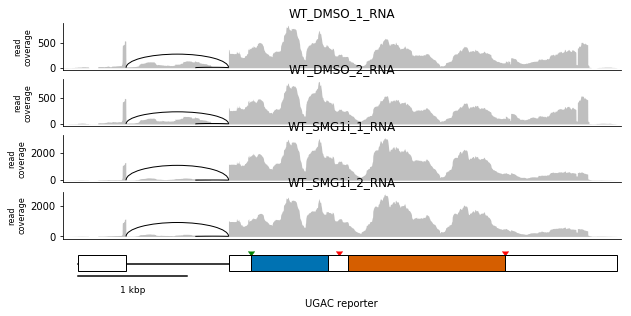

In [23]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import scipy.stats as stats
import numpy as np
plt.rcParams['pdf.fonttype'] = 42 #leaves most text as actual text in PDFs, not outlines
plt.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})

plots=[]
num_plots_wide = 1
num_plots_high = 5
fig, plots = plt.subplots(num_plots_high, figsize=(10*num_plots_wide, 1*num_plots_high), sharex=True)

positions = np.arange(5200)
plot_index = 0
for lib in RNA_experiment.libs[:4]:
    name = lib.lib_settings.sample_name
    coverage = np.array([float(pBZ105_coverage[name][pos]) for pos in positions])
    #plots[2].bar(positions-0.5, coverage, color=gray, linewidth=0, width=1, align='edge', alpha=0.5, snap=False, label='fractional coverage')
    plots[plot_index].fill_between(positions, coverage, color=gray, linewidth=0, alpha=0.5, label='coverage')
    plots[plot_index].set_ylabel('read\ncoverage', fontsize=8)
    plots[plot_index].set_title(name)
    for intron in pBZ105_introns[name].keys():
        radius = pBZ105_introns[name][intron]
        if radius>4: #require more than 4 reads
            #add 1 since STAR was 0-indexed and genomecov was 1-indexed
            arc = patches.Arc(((intron[1]+1+intron[0]+1)/2., 0), intron[1]-intron[0], 2*radius, linewidth=1, theta1=0.0, theta2=180)
            plots[plot_index].add_patch(arc)
    plot_index += 1

for plot in plots:
    plot.spines["top"].set_visible(False)
    plot.spines["right"].set_visible(False)
    #plot.set_ylim(-1000, 3000)

#draw transcript
plots[-1].set_ylim(0, 100)
transcript_bottom = 50

plots[-1].plot([136, 4046], [transcript_bottom+15, transcript_bottom+15], color=black)
plots[-1].add_patch(patches.Rectangle((136, transcript_bottom), (577+1)-(136), 35, facecolor="white", edgecolor = "black", zorder=10))
plots[-1].add_patch(patches.Rectangle((1516, transcript_bottom), (5064+1)-(1516), 35, facecolor="white", edgecolor = "black", zorder=10))
plots[-1].add_patch(patches.Rectangle((1724, transcript_bottom), (2422+1)-(1724), 35, facecolor=blue, edgecolor = "black", zorder=10)) 
plots[-1].add_patch(patches.Rectangle((2609, transcript_bottom), 753+684, 35, facecolor=vermillion, edgecolor = "black", zorder=10)) 
#plots[3].add_patch(patches.Rectangle((3362, transcript_bottom), 684, 35, facecolor=vermillion, edgecolor = "black", zorder=10, hatch='\\\\\\')) 
plots[-1].plot([1724], [85], marker=7, color="green")
plots[-1].plot([2521], [85], marker=7, color="red")
plots[-1].plot([4045], [85], marker=7, color="red")


plots[-1].spines["bottom"].set_visible(False)
plots[-1].spines["left"].set_visible(False)
plots[-1].set_xlabel('UGAC reporter')
plots[-1].set_yticks([])
plots[-1].set_xticks([])

plots[-1].set_xlim(0, 5100)
size_of_scale = 1000
plots[-1].plot([136, 136+size_of_scale], [40, 40], color=black)
plots[-1].text(136+(size_of_scale/2),  0, "{} kbp".format(size_of_scale/1000), size=9, horizontalalignment='center', verticalalignment='bottom')

plt.savefig('FS2E_pBZ105_RNA_Seq_introns.pdf', transparent=True)